In [113]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from itertools import product
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
import warnings
import json
warnings.filterwarnings("ignore")

def RMSE(series_true, series_predicted):
    return sum((series_true - series_predicted)**2 / len(series_true))**0.5

# Read data and change types

Here I read train and test tables which don't have lag features and features that are encoded via target encoding 

In [24]:
X_basic = pd.read_csv('data/X_without_lags_and_target_encoding.csv')
y_basic = pd.read_csv('data/y_without_lags_and_target_encoding.csv').item_cnt
X_test_basic = pd.read_csv('data/test_without_lags_and_target_encoding.csv', index_col='ID')

In [25]:
X_basic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10913850 entries, 0 to 10913849
Data columns (total 9 columns):
 #   Column            Dtype
---  ------            -----
 0   date_block_num    int64
 1   shop_id           int64
 2   item_id           int64
 3   item_category_id  int64
 4   super_category    int64
 5   category          int64
 6   city              int64
 7   shop_type         int64
 8   shop_name         int64
dtypes: int64(9)
memory usage: 749.4 MB


**date_block_num** - the serial number of month since the January, 2013.  
**shop_id** - the id of shop. Ranges from 0 to 59.  
**item_id** - the id of item. Ranges from 0 to 22169.  
**item_category_id** - the id of category. Ranges from 0 to 83.  
  
All item categories are splitted into super and simple category.  
**super_category** - the id of super category. Ranges from 0 to 14.  
**category** - the id of simple category. Ranges from 0 to 66.  
  
All shop names contain the city, type and name of shops.  
**city** - the id of city. Ranges from 0 to 28.  
**shop_type** - the id of shop type. Ranges from 0 to 8.  
**shop_name** - the id of shop name. Ranges from 0 to 50.

The memory is relatively high. So I change the types of all the features.

In [26]:
types = {
    'date_block_num': 'int8',
    'shop_id': 'int8',
    'item_id': 'int16',
    'item_category_id': 'int8',
    'super_category': 'int8',
    'category': 'int8',
    'city': 'int8',
    'shop_type': 'int8',
    'shop_name': 'int8'
}

In [27]:
X_basic = X_basic.astype(types)
X_test_basic = X_test_basic.astype(types)

In [28]:
X_basic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10913850 entries, 0 to 10913849
Data columns (total 9 columns):
 #   Column            Dtype
---  ------            -----
 0   date_block_num    int8 
 1   shop_id           int8 
 2   item_id           int16
 3   item_category_id  int8 
 4   super_category    int8 
 5   category          int8 
 6   city              int8 
 7   shop_type         int8 
 8   shop_name         int8 
dtypes: int16(1), int8(8)
memory usage: 104.1 MB


As you can see the memory size has decreased by 7 times!

Creating the train and valid datasets.

In [266]:
X_basic.drop(columns=['shop_id', 'item_id', 'item_category_id'], inplace=True)
X_test_basic.drop(columns=['shop_id', 'item_id', 'item_category_id'], inplace=True)

In [30]:
X_train_basic = X_basic[X_basic.date_block_num < 33]
y_train_basic = y_basic[X_basic.date_block_num < 33]

X_val_basic = X_basic[X_basic.date_block_num == 33]
y_val_basic = y_basic[X_basic.date_block_num == 33]

Here I read train and test tables which have lag features but don't have features that are encoded via target encoding 

In [31]:
X_lags = pd.read_csv('data/X_without_target_encoding.csv')
y_lags = pd.read_csv('data/y_without_target_encoding.csv').item_cnt
X_test_lags = pd.read_csv('data/test_without_target_encoding.csv', index_col='ID')

In [32]:
X_lags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6425094 entries, 0 to 6425093
Data columns (total 21 columns):
 #   Column            Dtype
---  ------            -----
 0   date_block_num    int64
 1   shop_id           int64
 2   item_id           int64
 3   item_category_id  int64
 4   super_category    int64
 5   category          int64
 6   city              int64
 7   shop_type         int64
 8   shop_name         int64
 9   item_cnt_lag1     int64
 10  item_cnt_lag2     int64
 11  item_cnt_lag3     int64
 12  item_cnt_lag4     int64
 13  item_cnt_lag5     int64
 14  item_cnt_lag6     int64
 15  item_cnt_lag7     int64
 16  item_cnt_lag8     int64
 17  item_cnt_lag9     int64
 18  item_cnt_lag10    int64
 19  item_cnt_lag11    int64
 20  item_cnt_lag12    int64
dtypes: int64(21)
memory usage: 1.0 GB


**item_cnt_lag{i}** for *i* from 1 to 12 is the value of **item_cnt** of the same row with **date_block_num** less on *i*.

As for previous tables, I will decrease the memory usage of this table. As first 8 features are also the features of the **X_basic** dataset, their new types are the same. So I just add new types for lag features.

In [33]:
types.update({
    f'item_cnt_lag{i}': 'int8' for i in range(1, 13)
})

In [34]:
X_lags = X_lags.astype(types)
X_test_lags = X_test_lags.astype(types)

In [35]:
X_lags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6425094 entries, 0 to 6425093
Data columns (total 21 columns):
 #   Column            Dtype
---  ------            -----
 0   date_block_num    int8 
 1   shop_id           int8 
 2   item_id           int16
 3   item_category_id  int8 
 4   super_category    int8 
 5   category          int8 
 6   city              int8 
 7   shop_type         int8 
 8   shop_name         int8 
 9   item_cnt_lag1     int8 
 10  item_cnt_lag2     int8 
 11  item_cnt_lag3     int8 
 12  item_cnt_lag4     int8 
 13  item_cnt_lag5     int8 
 14  item_cnt_lag6     int8 
 15  item_cnt_lag7     int8 
 16  item_cnt_lag8     int8 
 17  item_cnt_lag9     int8 
 18  item_cnt_lag10    int8 
 19  item_cnt_lag11    int8 
 20  item_cnt_lag12    int8 
dtypes: int16(1), int8(20)
memory usage: 134.8 MB


In [268]:
X_lags.drop(columns=['shop_id', 'item_id', 'item_category_id'], inplace=True)
X_test_lags.drop(columns=['shop_id', 'item_id', 'item_category_id'], inplace=True)

Creating the train and valid datasets.

In [37]:
X_train_lags = X_lags[X_lags.date_block_num < 33]
y_train_lags = y_lags[X_lags.date_block_num < 33]

X_val_lags = X_lags[X_lags.date_block_num == 33]
y_val_lags = y_lags[X_lags.date_block_num == 33]

Here I read train and test tables which have lag features and features that are encoded via target encoding 

In [38]:
X_full = pd.read_csv('data/X_full.csv')
y_full = pd.read_csv('data/y_full.csv').item_cnt
X_test_full = pd.read_csv('data/test_full.csv', index_col='ID')

In [39]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6425094 entries, 0 to 6425093
Data columns (total 29 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   date_block_num            int64  
 1   shop_id                   int64  
 2   item_id                   int64  
 3   item_category_id          int64  
 4   super_category            int64  
 5   category                  int64  
 6   city                      int64  
 7   shop_type                 int64  
 8   shop_name                 int64  
 9   item_cnt_lag1             int64  
 10  item_cnt_lag2             int64  
 11  item_cnt_lag3             int64  
 12  item_cnt_lag4             int64  
 13  item_cnt_lag5             int64  
 14  item_cnt_lag6             int64  
 15  item_cnt_lag7             int64  
 16  item_cnt_lag8             int64  
 17  item_cnt_lag9             int64  
 18  item_cnt_lag10            int64  
 19  item_cnt_lag11            int64  
 20  item_cnt_lag12          

**encoded_{feature}** are encoded features using target encoding.

As for previous tables, I will decrease the memory usage of this table. As first 21 features are also the features of the **X_lags** dataset, their new types are the same. So I just add new types for encoded features.

In [40]:
types.update({
    col: 'float32' for col in X_full.columns[21:]
})

In [41]:
X_full = X_full.astype(types)
X_test_full = X_test_full.astype(types)

In [42]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6425094 entries, 0 to 6425093
Data columns (total 29 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   date_block_num            int8   
 1   shop_id                   int8   
 2   item_id                   int16  
 3   item_category_id          int8   
 4   super_category            int8   
 5   category                  int8   
 6   city                      int8   
 7   shop_type                 int8   
 8   shop_name                 int8   
 9   item_cnt_lag1             int8   
 10  item_cnt_lag2             int8   
 11  item_cnt_lag3             int8   
 12  item_cnt_lag4             int8   
 13  item_cnt_lag5             int8   
 14  item_cnt_lag6             int8   
 15  item_cnt_lag7             int8   
 16  item_cnt_lag8             int8   
 17  item_cnt_lag9             int8   
 18  item_cnt_lag10            int8   
 19  item_cnt_lag11            int8   
 20  item_cnt_lag12          

In [270]:
X_full.drop(columns=X_full.columns[1:9], inplace=True)
X_test_full.drop(columns=X_test_full.columns[1:9], inplace=True)

Creating the train and valid datasets.

In [44]:
X_train_full = X_full[X_full.date_block_num < 33]
y_train_full = y_full[X_full.date_block_num < 33]

X_val_full = X_full[X_full.date_block_num == 33]
y_val_full = y_full[X_full.date_block_num == 33]

# Training models

I decided to use gradient boosting because it is the model that gives a high quality. I use lgbm because it is faster than simple gradient boosting or xgboost.

For 3 types of data I tune the **max_depth** parameter of lgbm. Also I use early stopping using validation dataset because it is more efficient than selection some value of the number of estimators. Then I plot the graphics of train and validation score from **max_depth** parameter and choose the values of this parameter which minimize the the validation score.

In [71]:
# the values of max_depth parameter to tune
max_depths = list(range(1, 30))

# cases of datasets
cases = [
    'basic',
    'lags',
    'lags and target encoding'
]

# common names of datasets in each case
datasets = {
    'basic': {
        'X_train': X_train_basic,
        'y_train': y_train_basic,
        'X_val': X_val_basic,
        'y_val': y_val_basic,
        'X_submission_train': X_basic,
        'y_submission_train': y_basic,
        'X_test': X_test_basic
    },
    'lags': {
        'X_train': X_train_lags,
        'y_train': y_train_lags,
        'X_val': X_val_lags,
        'y_val': y_val_lags,
        'X_submission_train': X_lags,
        'y_submission_train': y_lags,
        'X_test': X_test_lags
    },
    'lags and target encoding': {
        'X_train': X_train_full,
        'y_train': y_train_full,
        'X_val': X_val_full,
        'y_val': y_val_full,
        'X_submission_train': X_full,
        'y_submission_train': y_full,
        'X_test': X_test_full
    }
}

# categorical features in each case to set it
# as categorical_feature parameter of LGBMRegressor model
cat_features = {
    'basic': X_train_basic.columns.to_list(),
    'lags': X_train_basic.columns.to_list(),
    'lags and target encoding': X_train_full.columns[13:].to_list()
}

# all information about fitted models
all_models_info = {
    case: {
        'tuned_parameters': [],
        'train_scores': [],
        'val_scores': [],
        'best_iterations': [],
        'eval_times': [],
        'feature_importances': []
    }
    for case in cases
}

In [73]:
for case in cases:
    
    print(case)
    print('##########################')
    
    model_info = all_models_info[case]
    
    X_train = datasets[case]['X_train']
    y_train = datasets[case]['y_train']
    X_val = datasets[case]['X_val']
    y_val = datasets[case]['y_val']
    
    for max_depth in max_depths:
        
        start = datetime.datetime.now()
        model_info['tuned_parameters'] = max_depths
        
        print('max_depth:', max_depth)
        lgbm = LGBMRegressor(max_depth=max_depth)
        lgbm.fit(X_train,
                 y_train,
                 eval_set=[(X_val, y_val)],
                 eval_metric='l2',
                 early_stopping_rounds=20,
                 verbose=-1,
                 feature_name=X_train.columns.to_list(),
                 categorical_feature=cat_features[case])
        
        model_info['best_iterations'].append(lgbm.best_iteration_)
        model_info['train_scores'].append(RMSE(y_train, lgbm.predict(X_train).clip(0, 20)))
        model_info['val_scores'].append(RMSE(y_val, lgbm.predict(X_val).clip(0, 20)))
        model_info['eval_times'].append(datetime.datetime.now() - start)
        model_info['feature_importances'].append(
            list(zip(X_train.columns, lgbm.feature_importances_)))
        
        print('train RMSE:', model_info['train_scores'][-1], ' | ',
              'val RMSE:', model_info['val_scores'][-1])
        print('Evaluation time:', model_info['eval_times'][-1])
        print('------------------------------------------------------')

basic
##########################
max_depth: 1
[10]	valid_0's l2: 1.22827
[20]	valid_0's l2: 1.20162
[30]	valid_0's l2: 1.18526
[40]	valid_0's l2: 1.17708
[50]	valid_0's l2: 1.17212
[60]	valid_0's l2: 1.16931
[70]	valid_0's l2: 1.16694
[80]	valid_0's l2: 1.16535
[90]	valid_0's l2: 1.16494
[100]	valid_0's l2: 1.16363
train RMSE: 1.156488839447422  |  val RMSE: 1.0787172526430224
Evaluation time: 0:01:03.500428
------------------------------------------------------
max_depth: 2
[10]	valid_0's l2: 1.19187
[20]	valid_0's l2: 1.16914
[30]	valid_0's l2: 1.16041
[40]	valid_0's l2: 1.1573
[50]	valid_0's l2: 1.15294
[60]	valid_0's l2: 1.1499
[70]	valid_0's l2: 1.14958
[80]	valid_0's l2: 1.15026
train RMSE: 1.143568958972026  |  val RMSE: 1.0716833866828963
Evaluation time: 0:00:56.726763
------------------------------------------------------
max_depth: 3
[10]	valid_0's l2: 1.17267
[20]	valid_0's l2: 1.15161
[30]	valid_0's l2: 1.14523
[40]	valid_0's l2: 1.14307
[50]	valid_0's l2: 1.13642
[60]	val

[10]	valid_0's l2: 1.1254
[20]	valid_0's l2: 1.11529
[30]	valid_0's l2: 1.11361
[40]	valid_0's l2: 1.10582
[50]	valid_0's l2: 1.10131
[60]	valid_0's l2: 1.09424
[70]	valid_0's l2: 1.09318
[80]	valid_0's l2: 1.09256
[90]	valid_0's l2: 1.09052
[100]	valid_0's l2: 1.08879
train RMSE: 1.1081616827810201  |  val RMSE: 1.0433827150244657
Evaluation time: 0:01:47.511207
------------------------------------------------------
max_depth: 21
[10]	valid_0's l2: 1.1254
[20]	valid_0's l2: 1.11529
[30]	valid_0's l2: 1.11361
[40]	valid_0's l2: 1.10582
[50]	valid_0's l2: 1.10131
[60]	valid_0's l2: 1.09424
[70]	valid_0's l2: 1.09318
[80]	valid_0's l2: 1.09256
[90]	valid_0's l2: 1.09052
[100]	valid_0's l2: 1.08879
train RMSE: 1.1081616827810201  |  val RMSE: 1.0433827150244657
Evaluation time: 0:01:46.836249
------------------------------------------------------
max_depth: 22
[10]	valid_0's l2: 1.1254
[20]	valid_0's l2: 1.11529
[30]	valid_0's l2: 1.11361
[40]	valid_0's l2: 1.10582
[50]	valid_0's l2: 1.10

train RMSE: 0.8735684931493533  |  val RMSE: 0.9361193097952029
Evaluation time: 0:01:14.174894
------------------------------------------------------
max_depth: 10
[10]	valid_0's l2: 0.959059
[20]	valid_0's l2: 0.905964
[30]	valid_0's l2: 0.891594
[40]	valid_0's l2: 0.886133
[50]	valid_0's l2: 0.883381
[60]	valid_0's l2: 0.879855
[70]	valid_0's l2: 0.878695
[80]	valid_0's l2: 0.878068
[90]	valid_0's l2: 0.877025
[100]	valid_0's l2: 0.872363
train RMSE: 0.872415034021423  |  val RMSE: 0.9340014253537697
Evaluation time: 0:01:11.801234
------------------------------------------------------
max_depth: 11
[10]	valid_0's l2: 0.959059
[20]	valid_0's l2: 0.905976
[30]	valid_0's l2: 0.890007
[40]	valid_0's l2: 0.884168
[50]	valid_0's l2: 0.879345
[60]	valid_0's l2: 0.876539
[70]	valid_0's l2: 0.874731
[80]	valid_0's l2: 0.872393
[90]	valid_0's l2: 0.869664
[100]	valid_0's l2: 0.869226
train RMSE: 0.8717514914662642  |  val RMSE: 0.9322664024261538
Evaluation time: 0:01:12.051458
-------------

[20]	valid_0's l2: 0.904723
[30]	valid_0's l2: 0.890259
[40]	valid_0's l2: 0.882542
[50]	valid_0's l2: 0.880095
[60]	valid_0's l2: 0.877722
[70]	valid_0's l2: 0.876016
[80]	valid_0's l2: 0.875521
[90]	valid_0's l2: 0.873501
[100]	valid_0's l2: 0.872949
train RMSE: 0.8710579789043891  |  val RMSE: 0.9343160526923019
Evaluation time: 0:01:10.401875
------------------------------------------------------
max_depth: 29
[10]	valid_0's l2: 0.959059
[20]	valid_0's l2: 0.904723
[30]	valid_0's l2: 0.890259
[40]	valid_0's l2: 0.882542
[50]	valid_0's l2: 0.880095
[60]	valid_0's l2: 0.877722
[70]	valid_0's l2: 0.876016
[80]	valid_0's l2: 0.875521
[90]	valid_0's l2: 0.873501
[100]	valid_0's l2: 0.872949
train RMSE: 0.8710579789043891  |  val RMSE: 0.9343160526923019
Evaluation time: 0:01:12.841788
------------------------------------------------------
lags and target encoding
##########################
max_depth: 1
[10]	valid_0's l2: 1.07586
[20]	valid_0's l2: 1.02502
[30]	valid_0's l2: 1.0111
[40]	

The graphics of train and validation scores

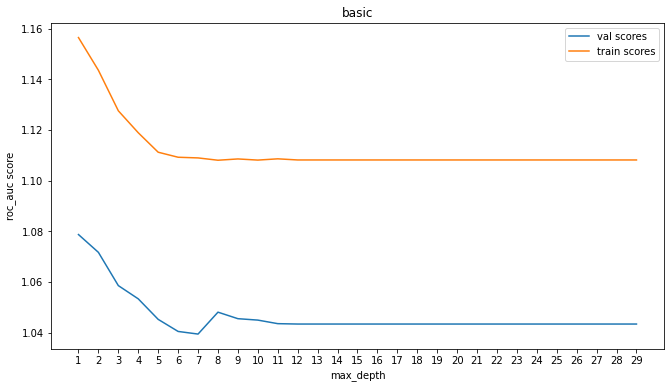

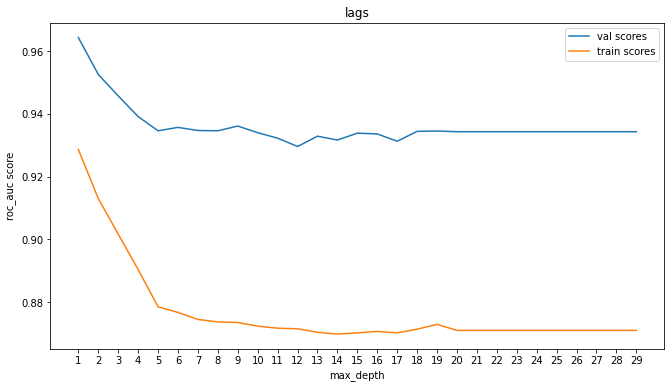

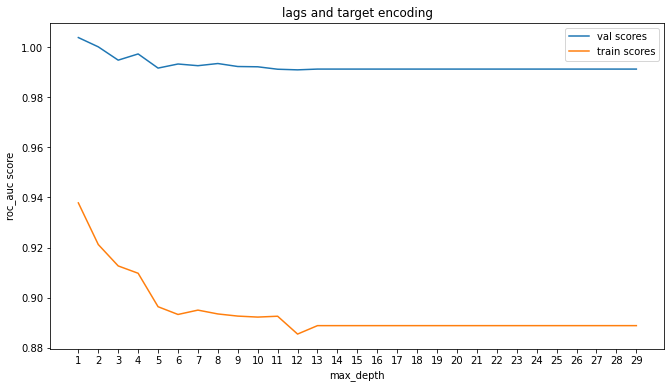

In [245]:
for i, case in enumerate(cases):
    model_info = all_models_info[case]
    
    plt.figure(figsize=(11, 6))
    plt.plot(model_info['tuned_parameters'], model_info['val_scores'])
    plt.plot(model_info['tuned_parameters'], model_info['train_scores'])
    plt.legend(['val scores', 'train scores'])
    plt.xlabel('max_depth')
    plt.ylabel('roc_auc score')
    plt.xticks(ticks=max_depths, labels=max_depths)
    plt.title(case)
    plt.show()

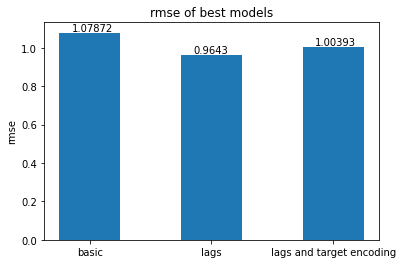

In [281]:
rmses = [max(all_models_info[case]['val_scores']) for case in cases]
plt.bar(x=cases, height=rmses, width=0.5)
plt.ylabel('rmse')
plt.title('rmse of best models')
for i, rmse in enumerate(rmses):
    plt.text(i-0.15, rmse + 0.01, str(round(rmse, 5)))
plt.show()

As you can see the best model is the model for dataset with lag features. The encoded features increased the rmse. So in this case they just make noise.

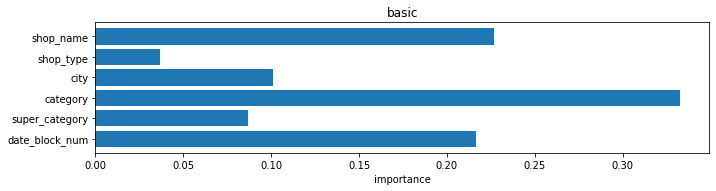

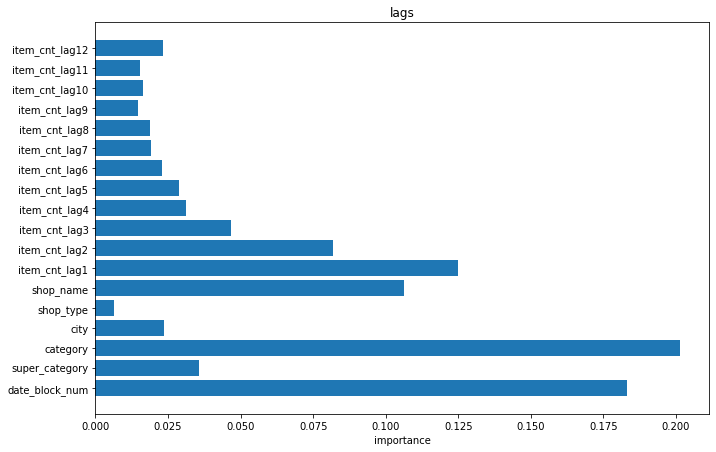

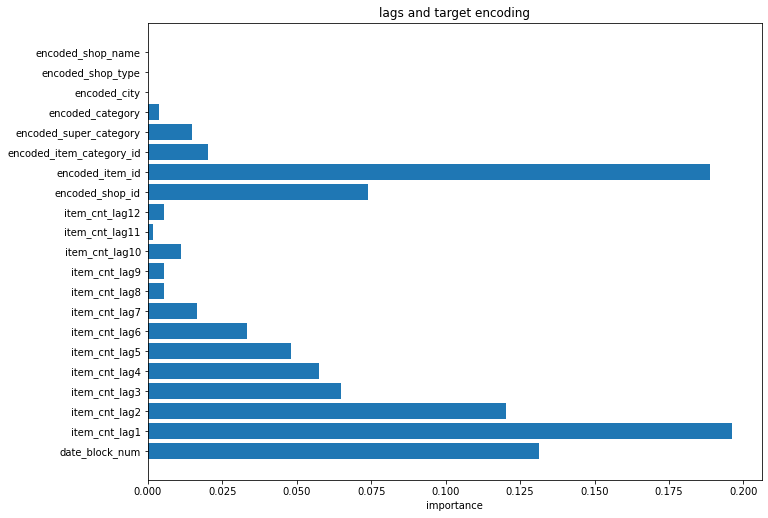

In [246]:
for case in cases:
    model_info = all_models_info[case]
    index_min = np.argmin(model_info['val_scores'])
    fis = dict(model_info['feature_importances'][index_min])
    
    plt.figure(figsize=(11, 0.4 * len(fis)))
    plt.barh(y=list(fis.keys()), width=np.array(list(fis.values())) / sum(fis.values()), )
    plt.title(case)
    plt.xlabel('importance')
    plt.show()

The **date_block_num**, **category** and **shop_name** features have the highest importance among non-lag and non-encoded features. The **encoded_item_id** and **encoded_shop_id** features have the highest importance among encoded features. The importance of lag features decreases inversely to its remoteness from the current month. The models fitted using the lag features have less rmse than without them. So they are important for training. The **shop_type** and **shop_name** after encoding have zero importance. It might be the reason of increasing rmse - they might be noise features.

# Submission

In [254]:
import glob
import re

def submit(y_predicted):
    my_submissions_paths = glob.glob('./data/my_submission_*.csv')
    nums = [int(re.findall(r'\d+', filepath)[0]) for filepath in my_submissions_paths]
    n = max(nums) + 1
    submission = pd.read_csv('data/sample_submission.csv')
    submission.item_cnt_month = y_predicted
    submission.to_csv(f'data/my_submission_{n}.csv', index=None)
    return f'data/my_submission_{n}.csv'

For all previous cases I will submit the results just to see the full result of training.  
Also in all cases I choose the **max_depth** parameter that minimizes the score on validation dataset.  
As I saved all best iterations to variables *best_iterations_\{basic|lags|full\}* I will use it to set the **n_estimators** parameter.

In [273]:
for case in cases:
    
    print(case)
    
    model_datasets = datasets[case]
    model_info = all_models_info[case]
    
    X_final_train = model_datasets['X_submission_train']
    y_final_train = model_datasets['y_submission_train']
    X_test = model_datasets['X_test']
    
    min_score_index = np.argmin(model_info['val_scores'])
    best_max_depth = model_info['tuned_parameters'][min_score_index]
    best_n_estimators = model_info['best_iterations'][min_score_index]
    
    best_lgbm = LGBMRegressor(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth
    )
    best_lgbm.fit(X_final_train, y_final_train)

    print('submission file:', submit(best_lgbm.predict(X_test).clip(0, 20)))
    print('\n##########################\n')

basic
submission file: data/my_submission_25.csv

##########################

lags
submission file: data/my_submission_26.csv

##########################

lags and target encoding
submission file: data/my_submission_27.csv

##########################



Basic score: 1.10808  
Lags score: 1.00452  
Lags and target encoding score: 1.04549

All scores are a bit greater than validation scores. But they are in same order as validation scores.  
As adding target encoding increases the rmse it disturbs the prediction.